In [1]:
from pathlib import Path
import numpy as np
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

2023-07-19 16:14:53.233701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:14:53.490913: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
CLASSES = [
    "background",
    "rod",
    "RBC/WBC",
    "Yeast",
    "misc",
    "single EPC",
    "few EPC",
    "several EPC",
]

In [4]:
def get_pixel_counts(mask_dir):
    mask_list = list(sorted(Path(mask_dir).rglob("*.tif")))
    class_counts = np.zeros(len(CLASSES))

    for mask_path in tqdm(mask_list):
        mask = np.array(load_img(mask_path))
        classes, counts = np.unique(mask, return_counts=True)
        class_counts[classes] += counts

    return class_counts

def plot_pixel_counts(mask_dir):
    class_counts = get_pixel_counts(mask_dir)

    fig, axes = plt.subplots(2, figsize=(10,10))

    axes[0].bar(CLASSES, class_counts / np.sum(class_counts))
    axes[0].set_yscale("log")
    axes[0].set_title("Class counts - pixels (w/ background)")
    axes[1].bar(CLASSES[1:], class_counts[1:] / np.sum(class_counts[1:]))
    axes[1].set_yscale("log")
    axes[1].set_title("Class counts - pixels (w/o background)")

def plot_object_counts(csv_path):
    pdf = pd.read_csv(csv_path)
    counts = pdf["label"].value_counts()
    counts = counts.sort_index()

    plt.figure(figsize=(10, 5))
    plt.bar(CLASSES[1:], counts.values)
    plt.title("Class counts - objects")
    plt.yscale("log")


# Train

In [21]:
train_pdf = pd.read_csv("../data/multiclass/train/labels.csv")

In [22]:
train_pdf

x           y   area            img                label
0      495.085657   26.152353   4483  4499 E 030721  class 5: single EPC
1     1189.266000  480.172000    320  4499 E 030721        class 4: misc
2      510.536000  136.180000    253  4499 E 030721        class 4: misc
3     1308.109000   58.555000    289  4499 E 030721        class 4: misc
4      492.901000  775.461000    461  4499 E 030721     class 2: RBC/WBC
...           ...         ...    ...            ...                  ...
1571   430.875000  711.820000   2816  8245 I 210721  class 5: single EPC
1572  1312.018000  746.040000    137  8245 I 210721     class 2: RBC/WBC
1573   608.232000  853.768000     56  8245 I 210721         class 1: rod
1574  1045.115000  355.678000  14540  8255 G 280721  class 5: single EPC
1575   193.838000  620.660000   6625  8263 A 161121  class 5: single EPC

[1576 rows x 5 columns]

In [60]:
def get_img(row, data_path):
    x, y = row[["x", "y"]]
    img = np.array(load_img(data_path / f"{row["img"]}.tif"))
    radius = np.sqrt(row["area"]/np.pi) * 1.5

    y_min = max(int(y-radius), 0)
    y_max = min(img.shape[0], int(y+radius))
    x_min = max(int(x-radius), 0)
    x_max = min(img.shape[1], int(x+radius))
    return img[y_min: y_max, x_min: x_max]


In [61]:
labels = np.unique(train_pdf["label"])

In [73]:
np.unique(train_pdf.label)

array(['class 1: rod', 'class 2: RBC/WBC', 'class 3: yeast',
       'class 4: misc', 'class 5: single EPC', 'class 6: few EPC ',
       'class 7: several EPC'], dtype=object)

0it [00:00, ?it/s]

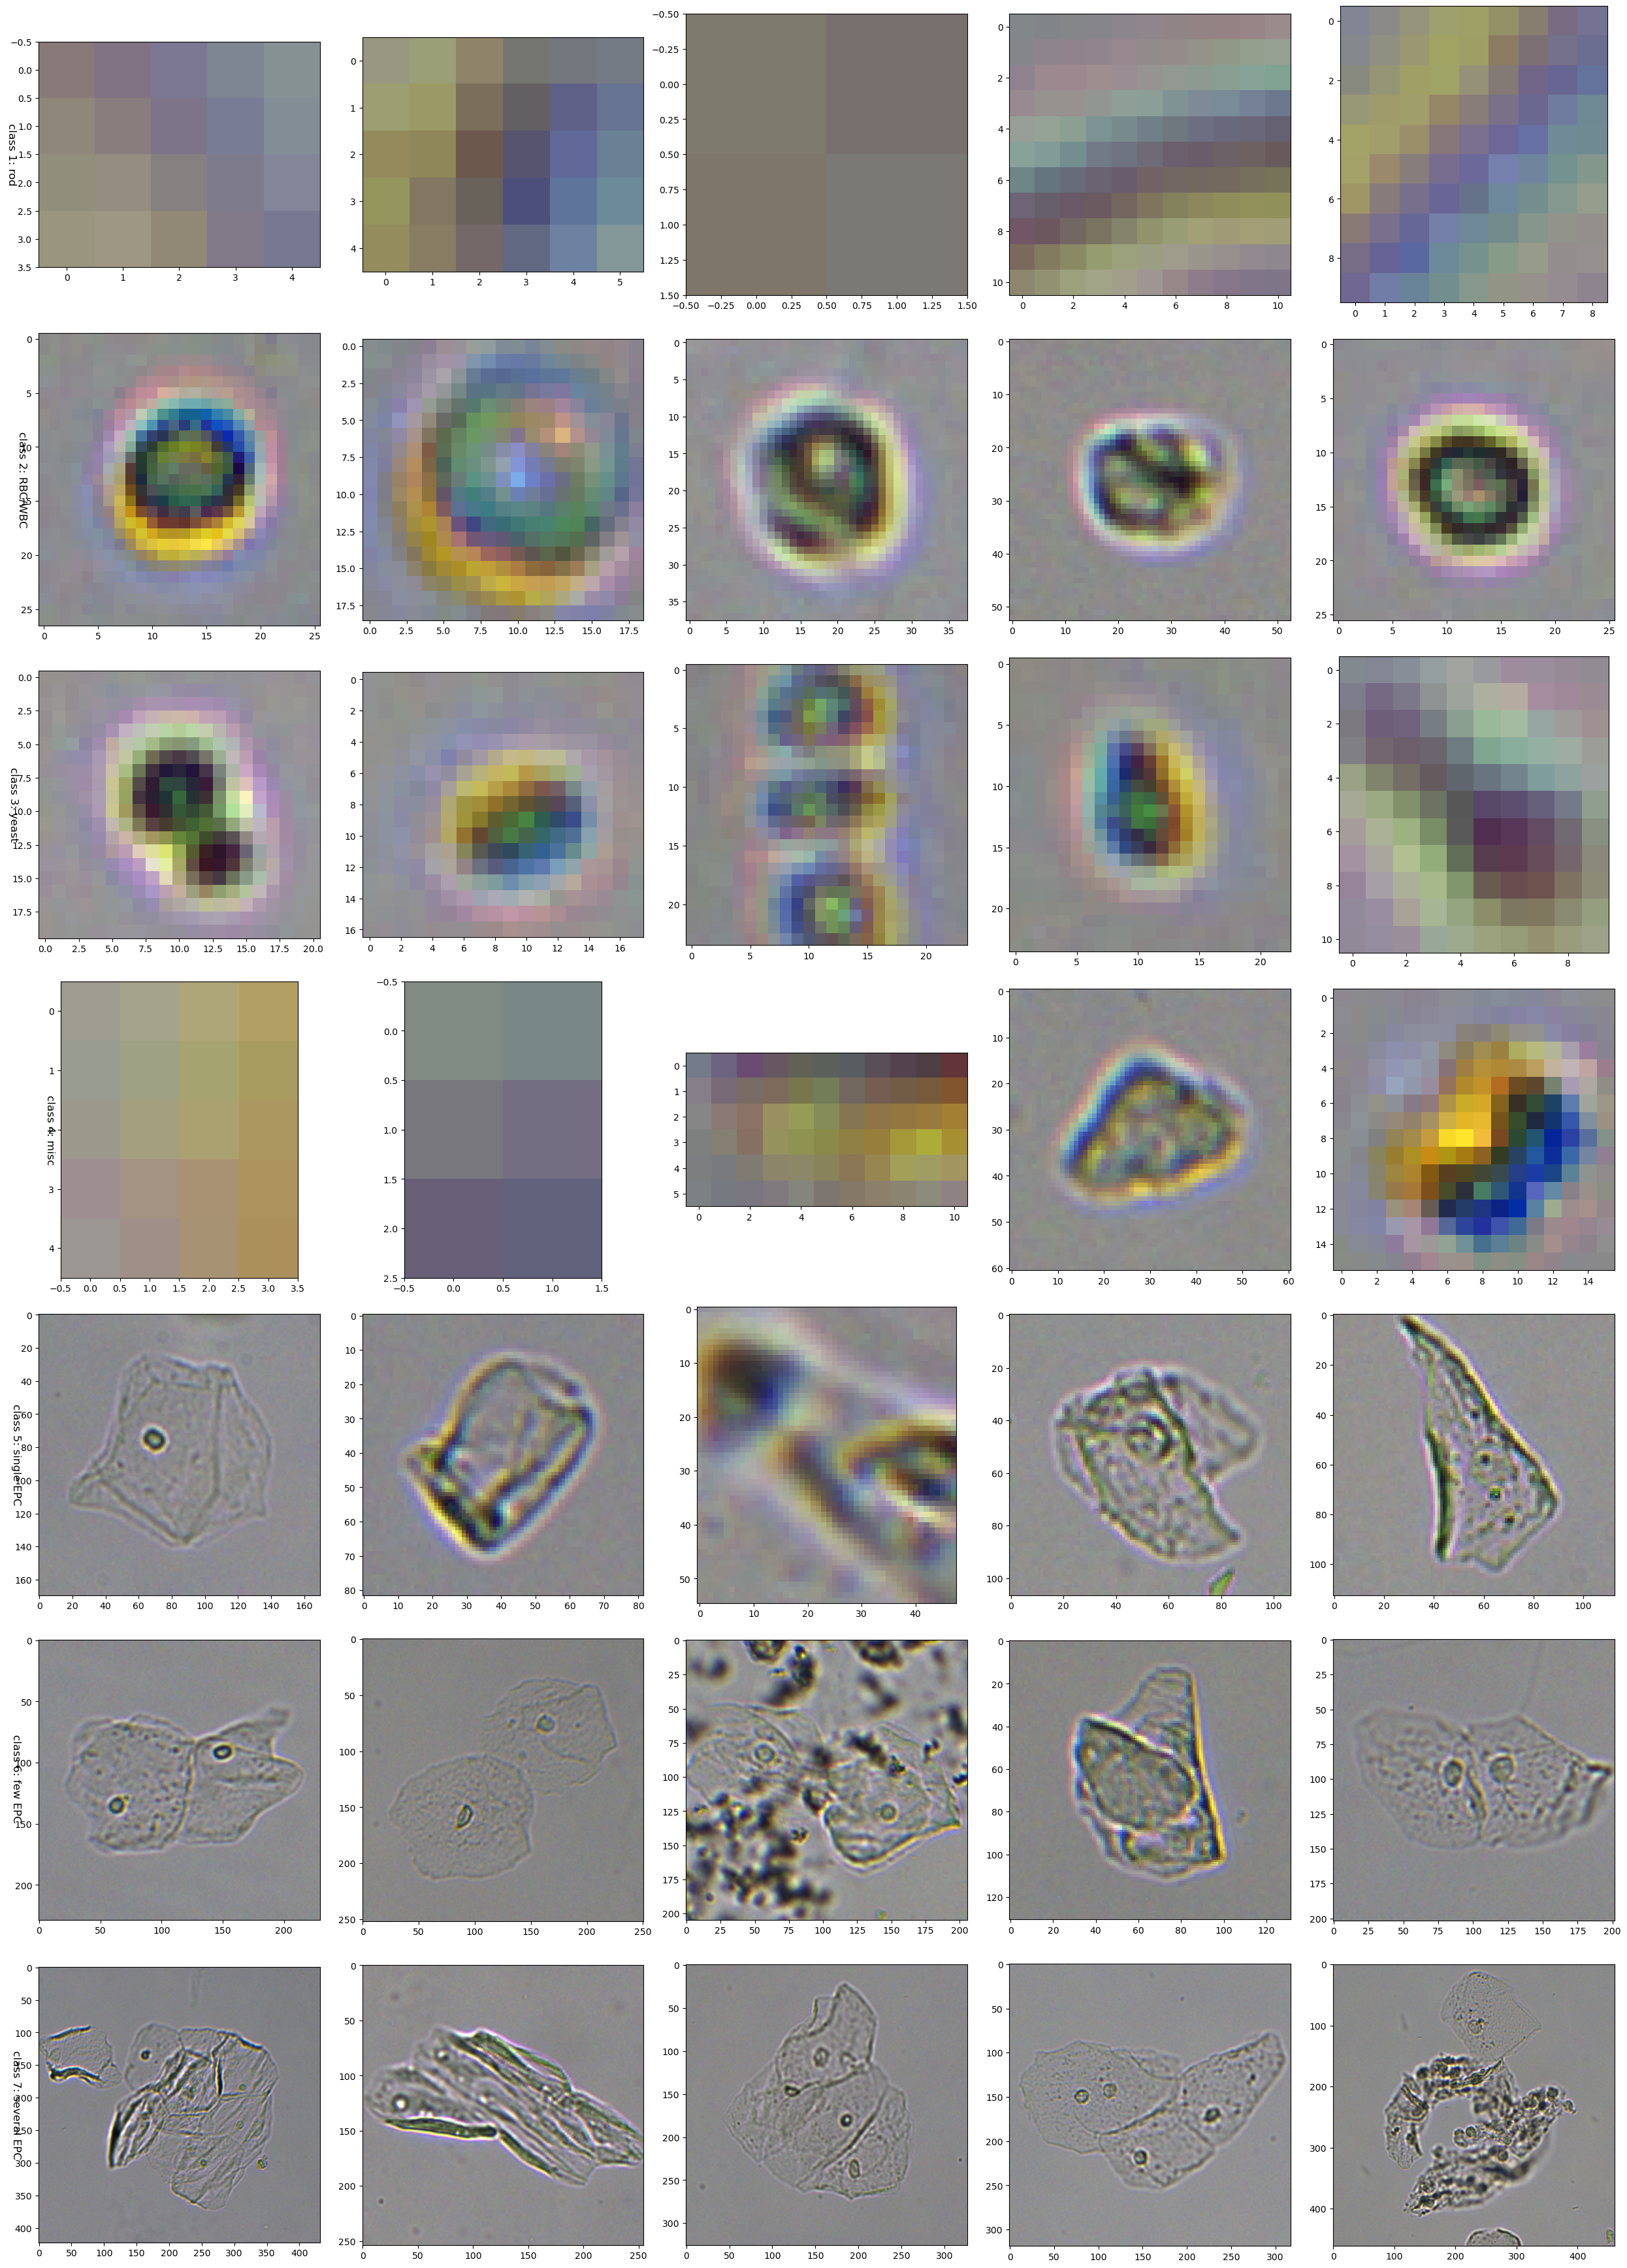

In [72]:
num_samples = 5
size = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(num_samples*size, len(labels)*size))
for row, label in tqdm(enumerate(labels)):
    pdf = train_pdf[train_pdf["label"] == label]
    axes[row, 0].set_ylabel(label, rotation=270, size="large")
    indices = np.random.choice(pdf.index, num_samples, replace=False)
    for col, idx in enumerate(indices):
        img = get_img(pdf.loc[idx], Path("../data/multiclass/train/img/cls/"))
        axes[row, col].imshow(img)

plt.tight_layout()

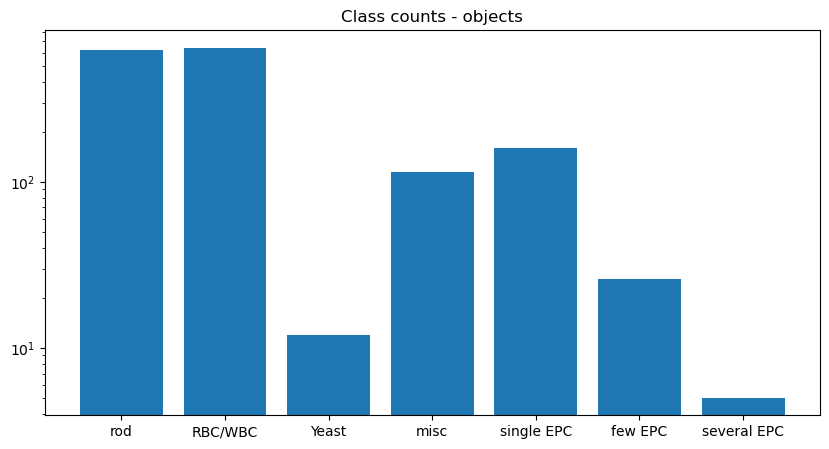

In [11]:
plot_object_counts("../data/multiclass/train/labels.csv")

  0%|          | 0/100 [00:00<?, ?it/s]

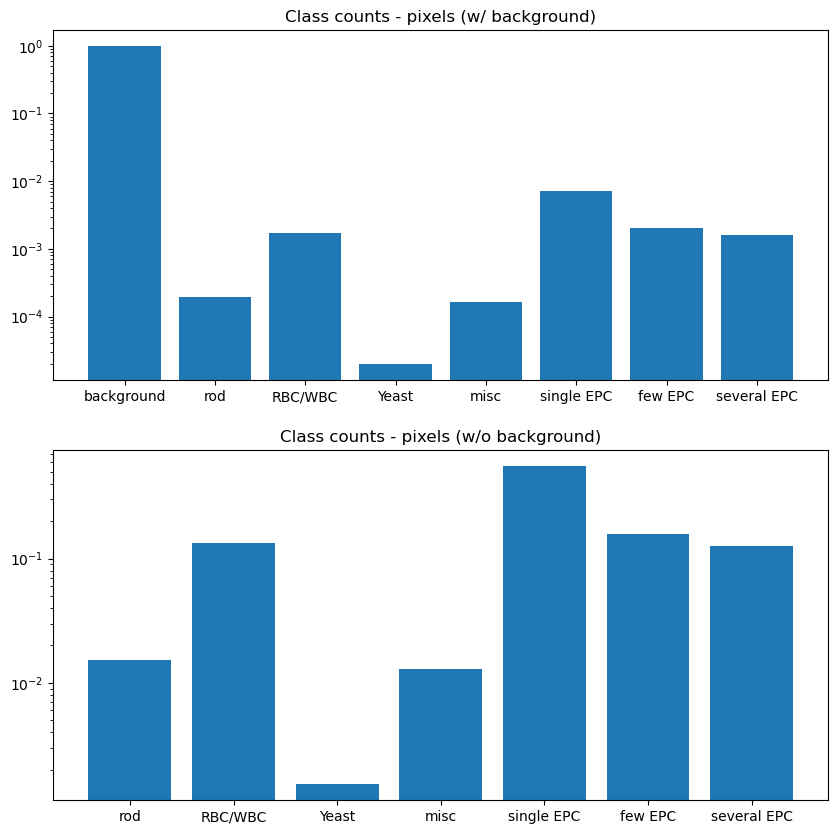

In [5]:
plot_pixel_counts("../data/ds1_multiclass/train/")

# Validation

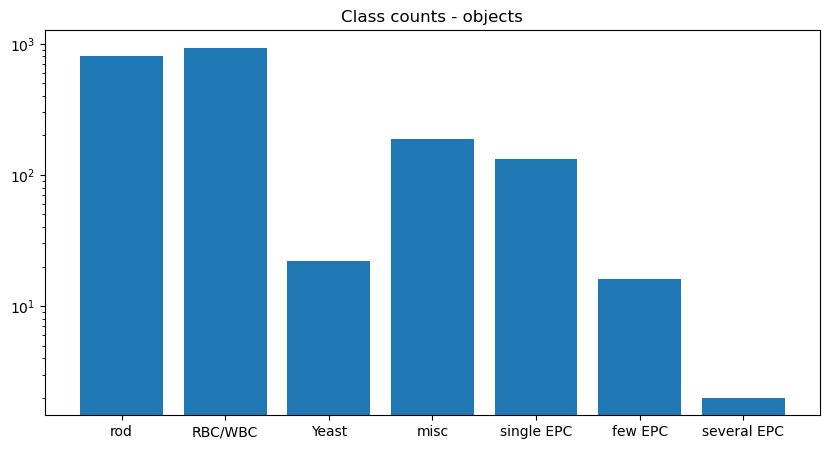

In [12]:
plot_object_counts("../data/chunks/validation")

  0%|          | 0/100 [00:00<?, ?it/s]

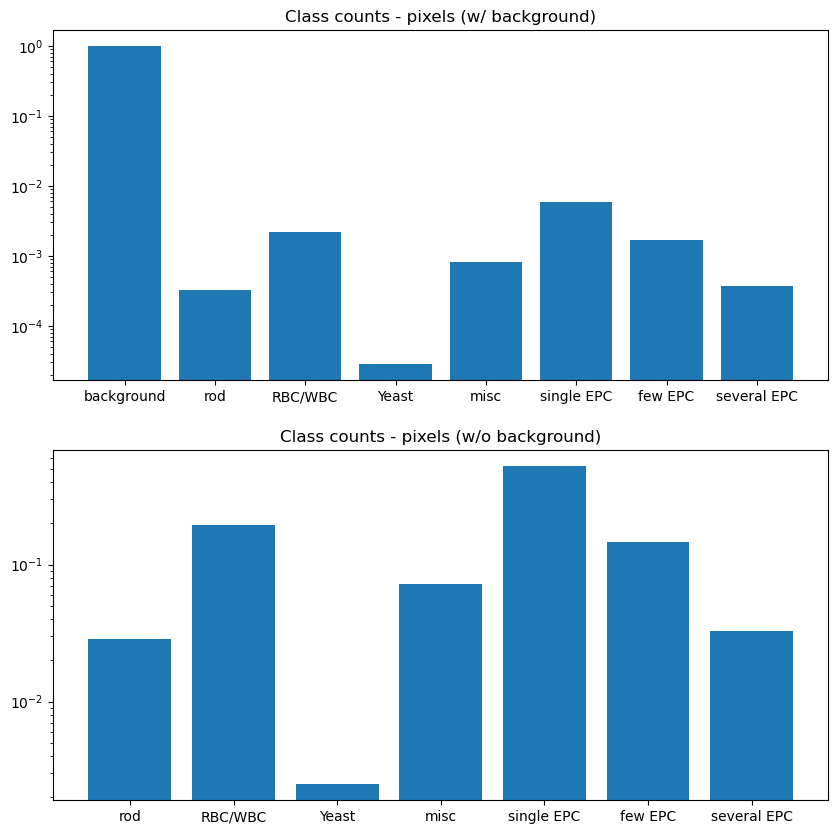

In [7]:
plot_pixel_counts("../data/ds1_multiclass/validation/")

# Test

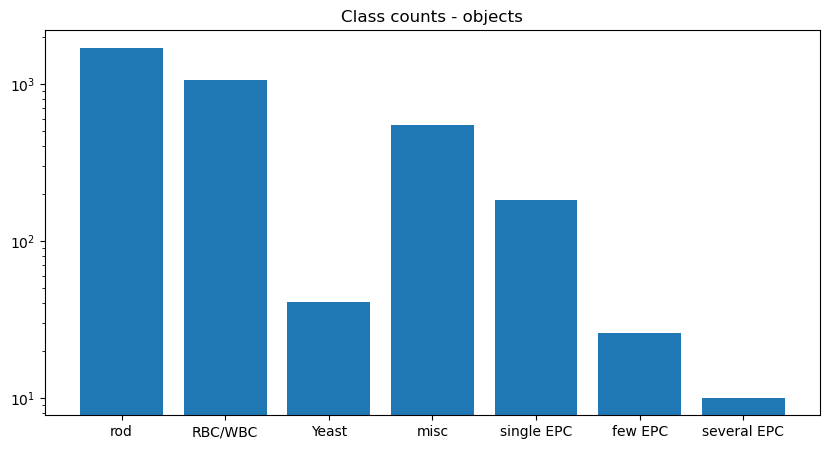

In [13]:
plot_object_counts("../data/chunks/test")

  0%|          | 0/100 [00:00<?, ?it/s]

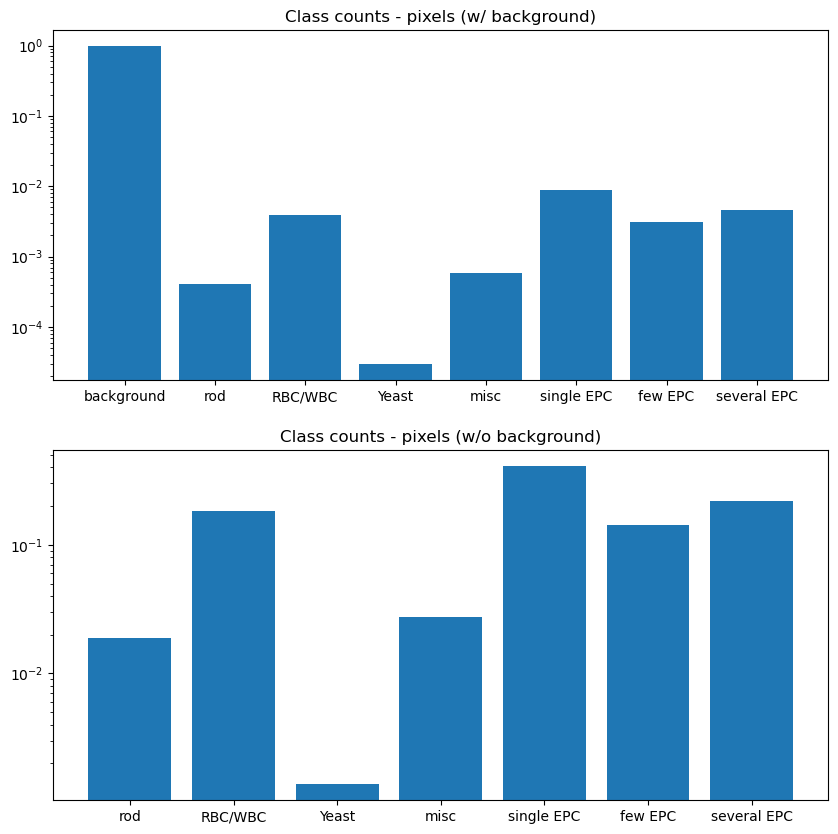

In [9]:
plot_pixel_counts("../data/ds1_multiclass/test/")